In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [54]:
diabetes_data = pd.read_csv('../diabetes.csv')
diabetes_data.head()

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_history,Diabetes
0,26,1,20.1,119,81,5.80,4.36,0.86,0.90,2.43,12.0,5.40,63.8,5.40,3.0,3.0,0,0
1,40,1,17.7,97,54,4.60,3.70,1.02,1.50,2.04,9.2,3.70,70.3,4.10,1.0,1.0,0,0
2,40,2,19.7,85,53,5.30,5.87,1.29,1.75,3.37,10.1,4.10,61.1,4.85,3.0,3.0,0,0
3,43,1,23.1,111,71,4.50,4.05,0.74,1.27,2.60,36.5,4.38,73.4,5.30,2.0,3.0,0,0
4,36,1,26.5,130,82,5.54,6.69,3.49,0.91,3.64,69.3,3.86,67.5,5.53,3.0,3.0,0,0


In [55]:
selected_features = ['drinking', 'Age', 'HDL', 'smoking', 'LDL', 'SBP', 'BMI', 'Gender', 'family_history', 'Chol', 'DBP']
X = diabetes_data[selected_features]
y = diabetes_data['Diabetes']

In [56]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the feature set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training SVM

Support Vector Machine (SVM) classifiers is trained with four different kernel functions, linear, rbf, poly and sigmoid. 

Their performances will then be evaluated using cross-validation and metrics like ROC AUC.

**From the results, we can see that SVM with rbf as its kernel function has the highest accuracy, ROC AUC and cross-validation mean accuracy.**

In [58]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
auc_scores = {}
cross_val_results = {}

for i, kernel in enumerate(kernels):
    svm_classifier = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42, probability=True)
    svm_classifier.fit(X_train, y_train)

    # Cross-validation
    cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=10)
    cross_val_results[kernel] = cv_scores

    # Make predictions
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    y_prob = svm_classifier.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    auc_scores[kernel] = roc_auc

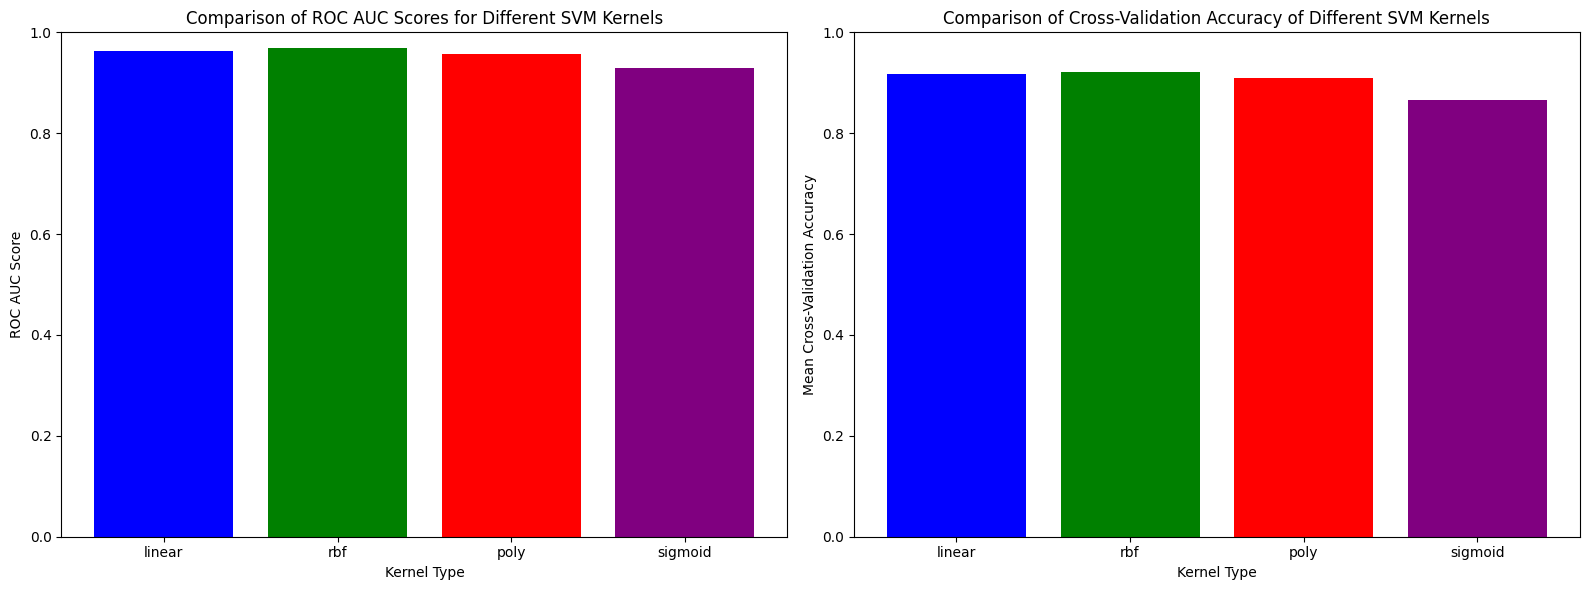

,Kernel,AUC,Mean CV Accuracy (%)
0,Linear,0.96,91.70
1,Rbf,0.97,92.15
2,Poly,0.96,90.94
3,Sigmoid,0.93,86.57


In [59]:
# Comparison of ROC AUC scores and cross-validation accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

kernels = list(auc_scores.keys())
auc_values = list(auc_scores.values())

# Plot ROC AUC scores (left subplot)
axes[0].bar(kernels, auc_values, color=['blue', 'green', 'red', 'purple'])
axes[0].set_xlabel('Kernel Type')
axes[0].set_ylabel('ROC AUC Score')
axes[0].set_title('Comparison of ROC AUC Scores for Different SVM Kernels')
axes[0].set_ylim(0.0, 1.0)

# Plot cross-validation mean accuracy (right subplot)
mean_cv_scores = [scores.mean() for scores in cross_val_results.values()]
axes[1].bar(kernels, mean_cv_scores, color=['blue', 'green', 'red', 'purple'])
axes[1].set_xlabel('Kernel Type')
axes[1].set_ylabel('Mean Cross-Validation Accuracy')
axes[1].set_title('Comparison of Cross-Validation Accuracy of Different SVM Kernels')
axes[1].set_ylim(0.0, 1.0)

# Adjust layout and show
plt.tight_layout()
plt.show()

summary_data = []

for kernel in auc_scores.keys():
    auc_score = auc_scores[kernel]
    cv_scores = cross_val_results[kernel]
    mean_cv_accuracy = cv_scores.mean() * 100

    summary_data.append({
        'Kernel': kernel.capitalize(),
        'AUC': round(auc_score, 2),
        'Mean CV Accuracy (%)': round(mean_cv_accuracy, 2),
    })

# Create the DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df


### Determine optimum training size for SVM classifier with rbf kernel

From the results, train size of 80% should be selected as our final model. Despite having a very slighlty lower score for accuracy, precision and recall for test, it has a slightly higher F1 score. Therefore, this would imply that the model with 80% training size will perform slightly better overall and less bias.

In [60]:
training_sizes = np.arange(0.1, 1.0, 0.1)  

results = []

for size in training_sizes:
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=size, random_state=50)

    scaler = StandardScaler()
    X_train_full = scaler.fit_transform(X_train_full)
    X_test = scaler.transform(X_test)

    # Initialize the model (e.g., Support Vector Classifier)
    model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)  # probability=True for ROC AUC

    # Train the model
    model.fit(X_train_full, y_train_full)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_full, y_train_full, cv=10) 

    # Evaluate on training data
    train_pred = model.predict(X_train_full)
    train_prob = model.predict_proba(X_train_full)[:, 1]  # Probability for ROC AUC

    # Evaluate on test data
    test_pred = model.predict(X_test)
    test_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC AUC

    results.append({
        'Training Size': size,
        'Train Accuracy': accuracy_score(y_train_full, train_pred),
        'Train Precision': precision_score(y_train_full, train_pred),
        'Train Recall': recall_score(y_train_full, train_pred),
        'Train F1 Score': f1_score(y_train_full, train_pred),
        'Train ROC AUC': roc_auc_score(y_train_full, train_prob),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Test Precision': precision_score(y_test, test_pred),
        'Test Recall': recall_score(y_test, test_pred),
        'Test F1 Score': f1_score(y_test, test_pred),
        'Test ROC AUC': roc_auc_score(y_test, test_prob),
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std(),
    })

results_df = pd.DataFrame(results)
results_df

,Training Size,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Train ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,CV Mean Accuracy,CV Accuracy Std
0,0.1,0.931667,0.984496,0.872852,0.925319,0.978425,0.915370,0.965289,0.862311,0.910899,0.960658,0.921667,0.040859
1,0.2,0.930000,0.991984,0.860870,0.921788,0.969603,0.918333,0.977006,0.858557,0.913960,0.957353,0.918333,0.018559
2,0.3,0.927778,0.993490,0.859234,0.921498,0.969338,0.917619,0.979370,0.854167,0.912494,0.961153,0.918333,0.012922
3,0.4,0.924583,0.989341,0.857263,0.918578,0.969495,0.920556,0.978630,0.860697,0.915882,0.964954,0.913750,0.013951
4,0.5,0.923667,0.986090,0.858104,0.917656,0.972490,0.923667,0.977679,0.868473,0.919846,0.965529,0.915667,0.012741
5,0.6,0.925000,0.987726,0.858989,0.918870,0.970668,0.920000,0.978585,0.861475,0.916303,0.965054,0.917500,0.017961
6,0.7,0.926190,0.988037,0.863183,0.921400,0.970409,0.926667,0.983523,0.867039,0.921615,0.964479,0.917857,0.014256
7,0.8,0.927292,0.985862,0.867690,0.923009,0.971865,0.928333,0.984586,0.867572,0.922383,0.965199,0.920625,0.006212
8,0.9,0.926481,0.984628,0.868132,0.922718,0.973674,0.933333,0.979167,0.870370,0.921569,0.970337,0.921481,0.009701


### Training SVM classifier with rbf kernel and train size of 80%

In [64]:
X_train_final, X_test, y_train_final, y_test = train_test_split(X, y, train_size=0.8, random_state=50)

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test = scaler.transform(X_test)

results = []

# Initialize the model (e.g., Support Vector Classifier)
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)  # probability=True for ROC AUC

# Train the model
model.fit(X_train_final, y_train_final)

# Cross-validation
cv_scores = cross_val_score(model, X_train_final, y_train_final, cv=10) 

# Evaluate on training data
train_pred = model.predict(X_train_final)
train_prob = model.predict_proba(X_train_final)[:, 1]  # Probability for ROC AUC

# Evaluate on test data
test_pred = model.predict(X_test)
test_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC AUC

results.append({
    'Train Accuracy': accuracy_score(y_train_final, train_pred),
    'Train Precision': precision_score(y_train_final, train_pred),
    'Train Recall': recall_score(y_train_final, train_pred),
    'Train F1 Score': f1_score(y_train_final, train_pred),
    'Train ROC AUC': roc_auc_score(y_train_final, train_prob),
    'Test Accuracy': accuracy_score(y_test, test_pred),
    'Test Precision': precision_score(y_test, test_pred),
    'Test Recall': recall_score(y_test, test_pred),
    'Test F1 Score': f1_score(y_test, test_pred),
    'Test ROC AUC': roc_auc_score(y_test, test_prob),
    'CV Mean Accuracy': cv_scores.mean(),
    'CV Accuracy Std': cv_scores.std(),
})

results_df = pd.DataFrame(results)
results_df

,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Train ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,CV Mean Accuracy,CV Accuracy Std
0,0.927292,0.985862,0.86769,0.923009,0.971865,0.928333,0.984586,0.867572,0.922383,0.965199,0.920625,0.006212
